#### Deploying a Machine Learning Model on Heroku with FastAPI
# Exploratory Data Analysis
#### Nikolas Hunt
#### ✉️ | November 2022

## Introduction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Ingestion

In [2]:
census = pd.read_csv('../data/census.csv')

## Exploration

In [3]:
census.head()

,age,workclass,fnlgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
census.shape

(32561, 15)

Each row represents one census taker. There are 32,561 rows in the datasets and 15 features:

In [5]:
census.columns.tolist()

['age',
 ' workclass',
 ' fnlgt',
 ' education',
 ' education-num',
 ' marital-status',
 ' occupation',
 ' relationship',
 ' race',
 ' sex',
 ' capital-gain',
 ' capital-loss',
 ' hours-per-week',
 ' native-country',
 ' salary']

The column names look suspicious to me with the indentation. It's clear that there is a leading space in the column names. Let's fix this now.

In [6]:
census = pd.read_csv('../data/census.csv', skipinitialspace = True)

In [7]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlgt           32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


It's good to see that there are no null values, but we need to look at each variable's contents to ensure that there isn't any whitespace characters or null synonyms in there, obscuring our understanding of the data.

There are a number of object type columns. Since this was loaded from a csv, these have to be text attributes, but I will need to inspect these to understand whether they are categorical, and the cardinality thereof.

In [8]:
categorical_cols = list(census.select_dtypes(include=['object']).columns)
for col in categorical_cols:
    print(col.upper())
    print('=============================')
    print(census[col].value_counts())
    print('\n')

WORKCLASS
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64


EDUCATION
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64


MARITAL-STATUS
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64


OCCUPATION
Prof-specialty       4140
Craft-repair         409

* As expected, '?' is being used as a synonym for null. I would like to speak with a subject matter expert as to what this means for the census too: was the answer not given, is '?' a valid option, or was the response illegible? Or a mixture of any or all of these?
* We only have '?' to deal with in ```workclass``` and ```native-country```, however.
* ```education``` probably has some sort of order, making it a likely ordinal feature; again, would need SME help.
* Other than this, the dataset is relatively clean and well populated regards the categorical features.
* **However, since the aim of this project is to predict the salary, there could be an issue with class imbalances; only 7,841 respondents answer with >$50k, representing only 24%**
* The cardinatlities are not too high either - all features may well be useful for bringing out patterns.

## Numerical Features

Let's look at the numerical features.

In [9]:
census.describe()

,age,fnlgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


- The age column looks clean with nothing remarkable.
- It's not clear what the meaning is for the ```fnlgt``` or ```education-num``` fields are. It's therefore difficult to talk about the distirbution of these columns.
- ```capital-gain``` and ```capital-loss``` are highly skewed. The former looks to have potentially had clipping applied at 99,999. Either way, it looks like we have some outliers.
- Likewise, ```hours-per-week``` doesn't look dirty, but the 99 maximum looks potentially suspicious, and we would have to see the frequency of this value to understand more if this field was clipped.

array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'fnlgt'}>],
       [<AxesSubplot: title={'center': 'education-num'}>,
        <AxesSubplot: title={'center': 'capital-gain'}>],
       [<AxesSubplot: title={'center': 'capital-loss'}>,
        <AxesSubplot: title={'center': 'hours-per-week'}>]], dtype=object)

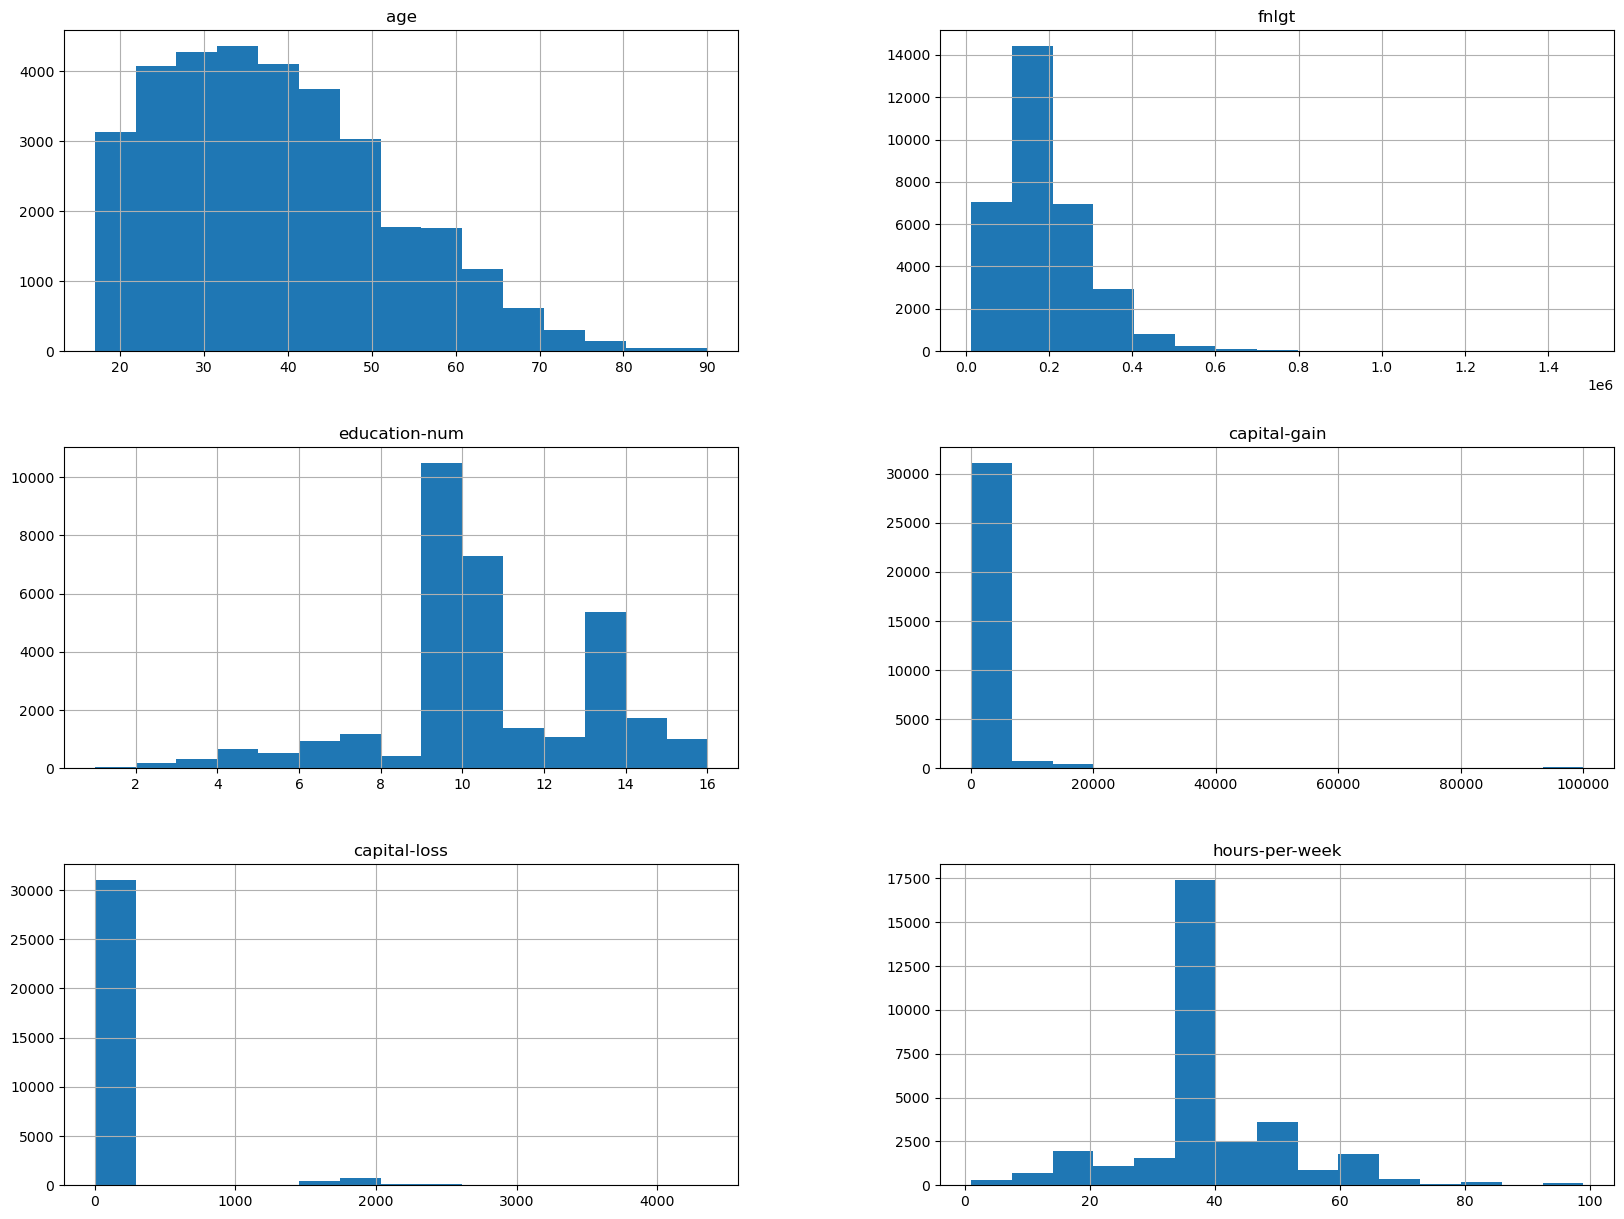

In [10]:
census.hist(bins=15, figsize=(20,15))

These histograms confirm the observations above, and hint that the age of 99 is not a clipping point.

We will need to consider outlier handling for:
- fnlgt
- capital-gain
- capital-loss

If we do not handle outliers, these tail-heavy features may need to be transformed to have more bell-shaped distributions, since patterns in such tail-heavy distributions are difficult for some machine learning algorithms to discover.

I'll need to discuss with the subject matter expert in the first instance to make an informed decision on this, or have outlier removal engineered as a hyperparameter and experiment once we have a training pipeline up and running.